In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
e_data = pd.read_csv('../data/NTD_Capital_Expenditures.csv')

In [3]:
e_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25356 entries, 0 to 25355
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Agency                               25322 non-null  object 
 1   City                                 25279 non-null  object 
 2   State                                25322 non-null  object 
 3   NTD ID                               25322 non-null  object 
 4   Reporter Type                        25322 non-null  object 
 5   Report Year                          25356 non-null  int64  
 6   Primary UZA Population               24733 non-null  float64
 7   Agency VOMS                          25322 non-null  object 
 8   Mode                                 25117 non-null  object 
 9   TOS                                  25117 non-null  object 
 10  Mode VOMS                            25304 non-null  object 
 11  Guideway                    

In [5]:
e_data['Reporter Type'].unique()

array(['Full', 'Rural', 'Reduced', 'Building', 'Separate', 'Group',
       'Planning', 'State', 'Asset', nan], dtype=object)

Start by looking at the total annual expenditures per year across the US.

In [6]:
yr_all = e_data.groupby(['Report Year'])['Total'].sum()

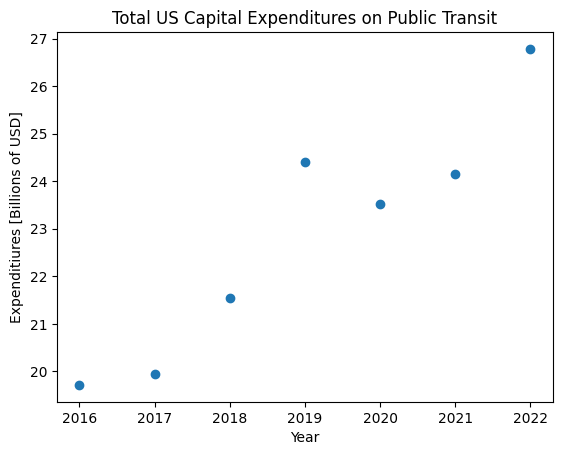

In [7]:
plt.scatter(x = yr_all.index, y = yr_all.array / 1e9)
plt.xlabel("Year")
plt.ylabel("Expenditiures [Billions of USD]")
plt.title("Total US Capital Expenditures on Public Transit")
plt.show()

Next, examine the total expenditures per capita (total population is the service population.)

In [8]:
e_data['TotPerCap'] = e_data['Total'] / e_data['Primary UZA Population']
dat_to_use = e_data[(e_data['Primary UZA Population'] > 0)]
per_cap_tot = dat_to_use.groupby(['Report Year'])['TotPerCap'].sum()

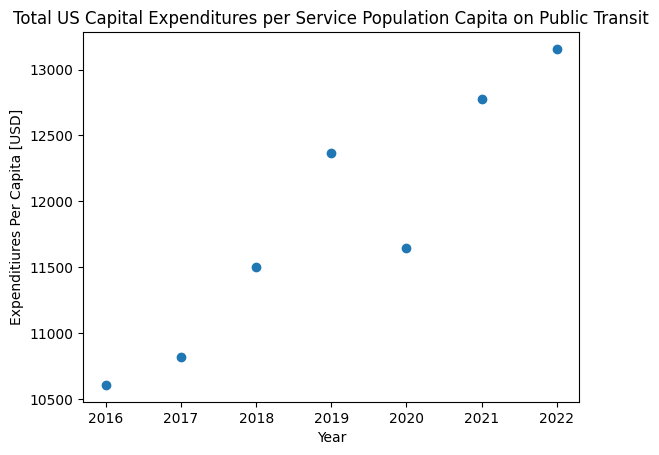

In [9]:
plt.scatter(x = per_cap_tot.index, y = per_cap_tot.array)
plt.xlabel("Year")
plt.ylabel("Expenditiures Per Capita [USD]")
plt.title("Total US Capital Expenditures per Service Population Capita on Public Transit")
plt.show()

Same general trend line. The global increase is not hiding per capita stagnation in spending. Turns out money is going to transit right now. Although probably unequally. That's the next thing to look at. We have state level data, so we can try using that. We will also use per capita numbers to try to avoid a population map.

In [15]:
per_cap_states = dat_to_use.groupby(by = ['Report Year', 'State'])['TotPerCap'].sum()
temp = per_cap_states.to_frame().reset_index()
fig = px.box(temp, x = 'Report Year', y = 'TotPerCap', hover_name='State',
       title='Per Capita Spending on Transit, By Year, for each State',
       labels={'Report Year': 'Report Year', 'TotPerCap': 'Total State Spending per Capita [USD]'})
fig.show()

In [17]:
# Exports the above chart to the web for embed. Does not need to be rerun unless plot is changed.
#import chart_studio
#import chart_studio.plotly as py
#user = 'dolaya'
#api_key = 'ZQH2NQPNYxImVLcbNiyY'
#chart_studio.tools.set_credentials_file(username=user, api_key=api_key)
#py.plot(fig, filename = 'state_pc', auto_open=True)

'https://plotly.com/~dolaya/1/'

We can also try to get a more granular picture of where all this money goes. Full reporters have to give a more detailed snapshot of how they use their money, so we can look into the breakdown there.

In [19]:
full = e_data[e_data['Reporter Type'] == "Full"]
p_cat = full.groupby(by = ['Agency', 'Report Year'])

In [40]:
s_test = p_cat[list(full.columns[11:])].sum().reset_index()
s_test = s_test[s_test['Total'] > 0]
tot_obs = sum(s_test['Total'].notna())
agg_sum = s_test.iloc[:,2:11].divide(s_test['Total'], axis=0).replace(0, np.nan)

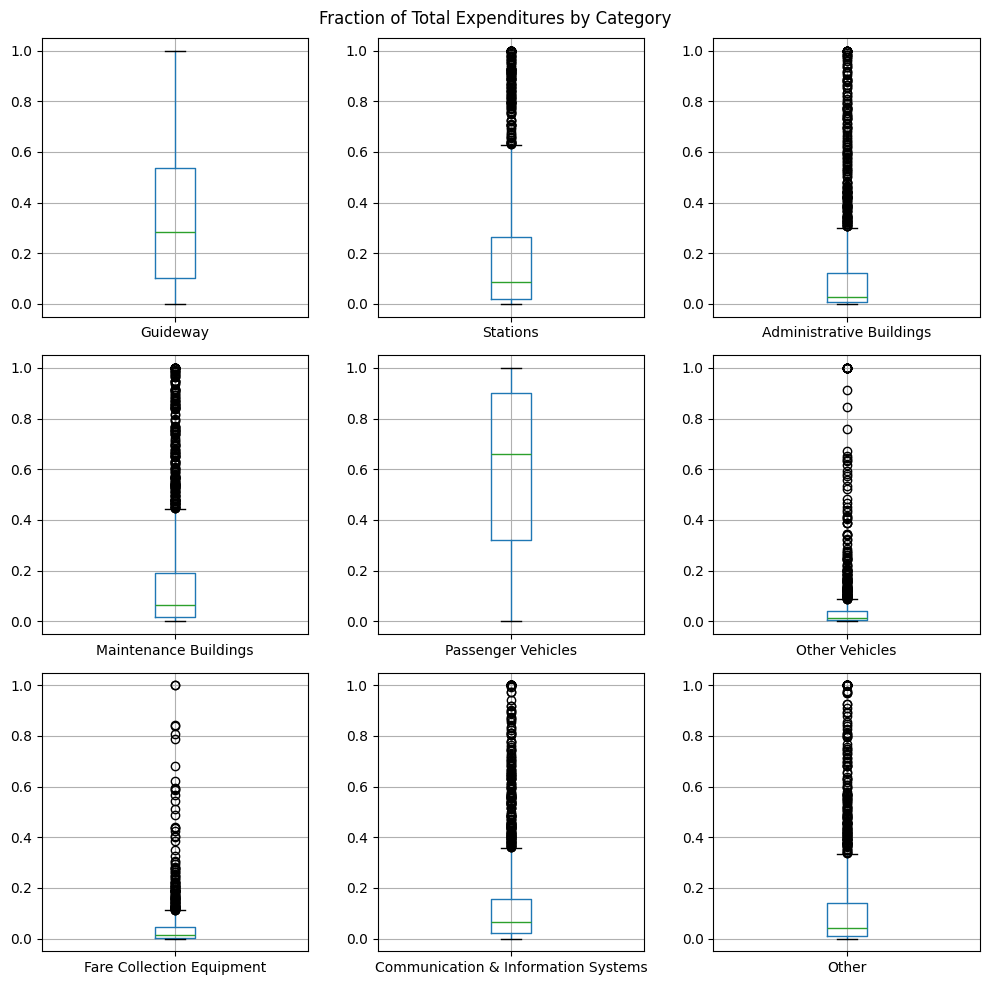

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10,10])
fig.suptitle("Fraction of Total Expenditures by Category")
for axis, col in zip(ax.flatten(), agg_sum):
    agg_sum.boxplot(col, ax=axis)
fig.tight_layout()

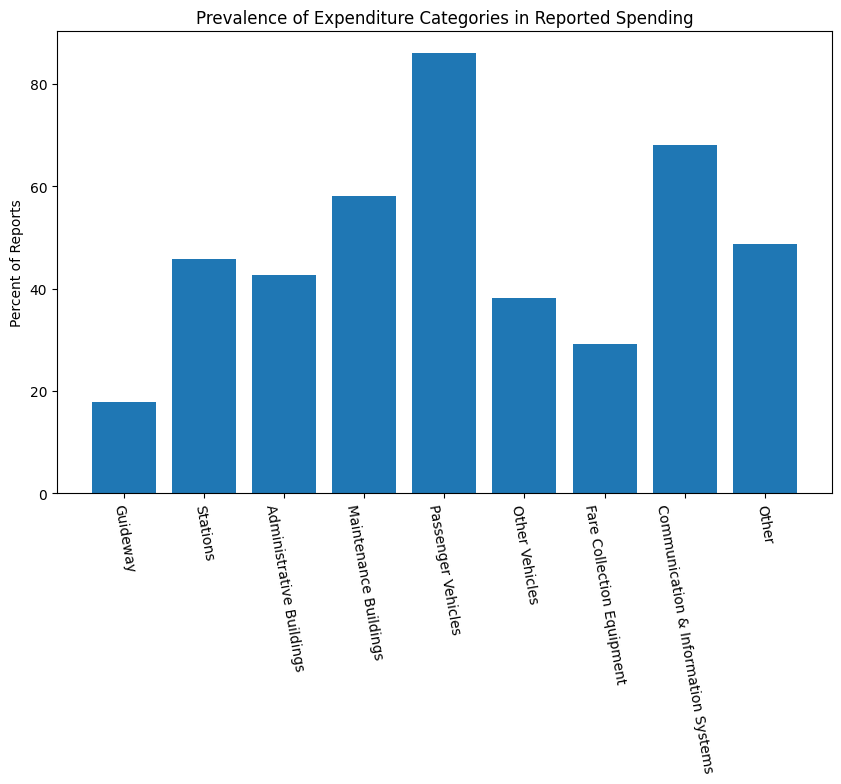

In [41]:
counts = [0] * agg_sum.shape[1]
for i, col in enumerate(agg_sum):
    counts[i] = sum(agg_sum[col].notna())
fig = plt.figure(figsize=[10,6])
fig.tight_layout()
plt.bar(x = agg_sum.columns, height=[100 * c / tot_obs for c in counts])
plt.xticks(rotation=-80)
plt.title(label="Prevalence of Expenditure Categories in Reported Spending")
plt.ylabel("Percent of Reports")
plt.show()